This is the notebook to use to generate a figure. 
For this, you need to have to have the following: 
- the simulated dataset (w3c)
- the set `.env` at the root with `$WORKSPACE` and `$DEMAPPER`

## Step 1) run the Mappers on the configs

The following script will generate the Mapper results, shape graphs, plots, and stats for each configuration set in the configuration.
We will run two sets of DeMapper configurations (they will run for a while):

```
./code/utils/run_mapper.sh --poolsize 4 mappers_w3c_embed1.json w3c

```


## Step 2) Analyze the created Mappers graphs (circleness, ...)

Once all the mappers have been computed for the configs, you should analyze the shape graphs based on the circleness criteria and the other statistics:

```
CONF=mappers_w3c_embed1.json
```

Run the below for each of the above configurations:

```
source .env
# module load matlab # Maybe run this if you are running in SLURM
COHORT_PATH="$WORKSPACE/data/w3c/cohort.csv"
DATAFOLDER="$WORKSPACE/results/w3c/${CONF}/"
OUTPUT_DIR="$WORKSPACE/results/w3c/analysis/${CONF}/"
ARGS="datafolder='${DATAFOLDER}'; cohort_path='${COHORT_PATH}'; output_dir='${OUTPUT_DIR}';"
matlab -nodesktop -r "${ARGS} run('$WORKSPACE/code/w3c/circle_test_multitiming.m')"

```

For the rest of the criteria, run the following python script:

```
python3 $WORKSPACE/code/utils/cache.py compute_stats \
    $WORKSPACE/data/w3c/cohort.csv \
    $WORKSPACE/results/w3c/${CONF}/ \
    --output_dir $WORKSPACE/results/w3c/analysis/${CONF}/
```

The above two commands will generate tables of stats within `analysis/${CONF}` directory. 

## Step 3) Generate the figures

In [1]:
import csv
import os
import math
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import Image as IPyImage, display
from PIL import Image

sns.set_theme(style='white')

# demapper imports for the analysis
from code.utils.analyze import extract_dataset, get_all_parameters
from code.utils.config_w3c import DATASETS, FILTERS
from code.utils.config_mapper import extract_params_f
from code.utils.utils import filter_dataframe, count_passing, add_col_passing
from code.utils.plot_grids import plot_grid_params

### Figure (a)

In [2]:
PICKED_DATASET = 'w3c-embed1'

datadir = DATASETS[PICKED_DATASET]
stats_path = os.path.join(datadir, 'compute_stats-combined.csv')
results_path = os.path.join(datadir, 'scores-all.csv')

SBJS = ['SBJ99']
table = {sbj: [] for sbj in SBJS}
for filter_by in FILTERS[PICKED_DATASET]:
    print(filter_by)
    df_fb, max_values = extract_dataset(stats_path, results_path, filter_by, extract_params_f)
            
    target_metrics_limits = {
        'TransitionBetweeness': [0, max_values['TransitionBetweeness'] * 0.99], # Need the data first, add later
        'coverage_nodes': [0.7, 1.0],
        'distances_entropy': [2.0, 10000.0],
        'hrfdur_stat': [0.15, 1.0],
    }
    
    if 'tSNE' in filter_by:
        df_fb['embed'] = df_fb.apply(lambda row: 'tSNE p={}'.format(row['perplexity']), axis=1)
    
        
    embedVals = df_fb['embed'].drop_duplicates().to_numpy()
    KVals = df_fb['K'].drop_duplicates().to_numpy()
    
    for sbj in SBJS:
        for embed in embedVals:
            df_e = filter_dataframe(df_fb, {'embed': [embed] })
            KVals = df_e['K'].drop_duplicates().to_numpy()
            for k in KVals:
                fdf = filter_dataframe(df_fb, {'embed': [embed], 'K': [k], 'SBJ': [sbj] })
                cnt = count_passing(fdf, target_metrics_limits)
                table[sbj].append({
                    'embed': embed,
                    'K': k,
                    'count': cnt,
                    'perc': cnt / len(fdf) * 100.0,
                    'total': len(fdf),
                    'Embedding type': 'Non-Parametric' if filter_by == 'EmbedBDLMapperWtd' else 'Parametric'
                })

df = pd.DataFrame(data=table[SBJS[0]])

EmbedBDLMapperWtd
len(stats):  4250
len(results):  4250
tSNEBDLMapperWtd
len(stats):  4250
len(results):  4250
KEmbedBDLMapper
len(stats):  4250
len(results):  4250


In [3]:
order = [
 'CMDS',
 'PCA',
 'LDA',
 'FactorAnalysis',
 'DiffusionMaps',
 'Sammon',
 'UMAP',
 'Isomap',
 'LLE',
 'HessianLLE',
 'Laplacian',
 'LTSA',
 'tSNE p=5',
 'tSNE p=20',
 'tSNE p=50',]

cols = (['#7DC0A7'] * 6) + (['#ED936B'] * 6) + (['#919FC7'] * 3)

plt.figure(figsize=(4.5,7))
g = sns.boxplot(data=df, x='count', y='embed', order=order, palette=cols)#, palette='Set2')
plt.xlim([-1, 25])
plt.legend([], frameon=False)
plt.ylabel('')
plt.xlabel('Count of correct mapper graphs')
plt.grid(alpha=0.1, axis='x')
plt.tight_layout()
savefig_path = os.path.join(
        datadir, 'embeds_analysis.png')
plt.savefig(savefig_path, dpi=300)
# plt.show()
plt.close()

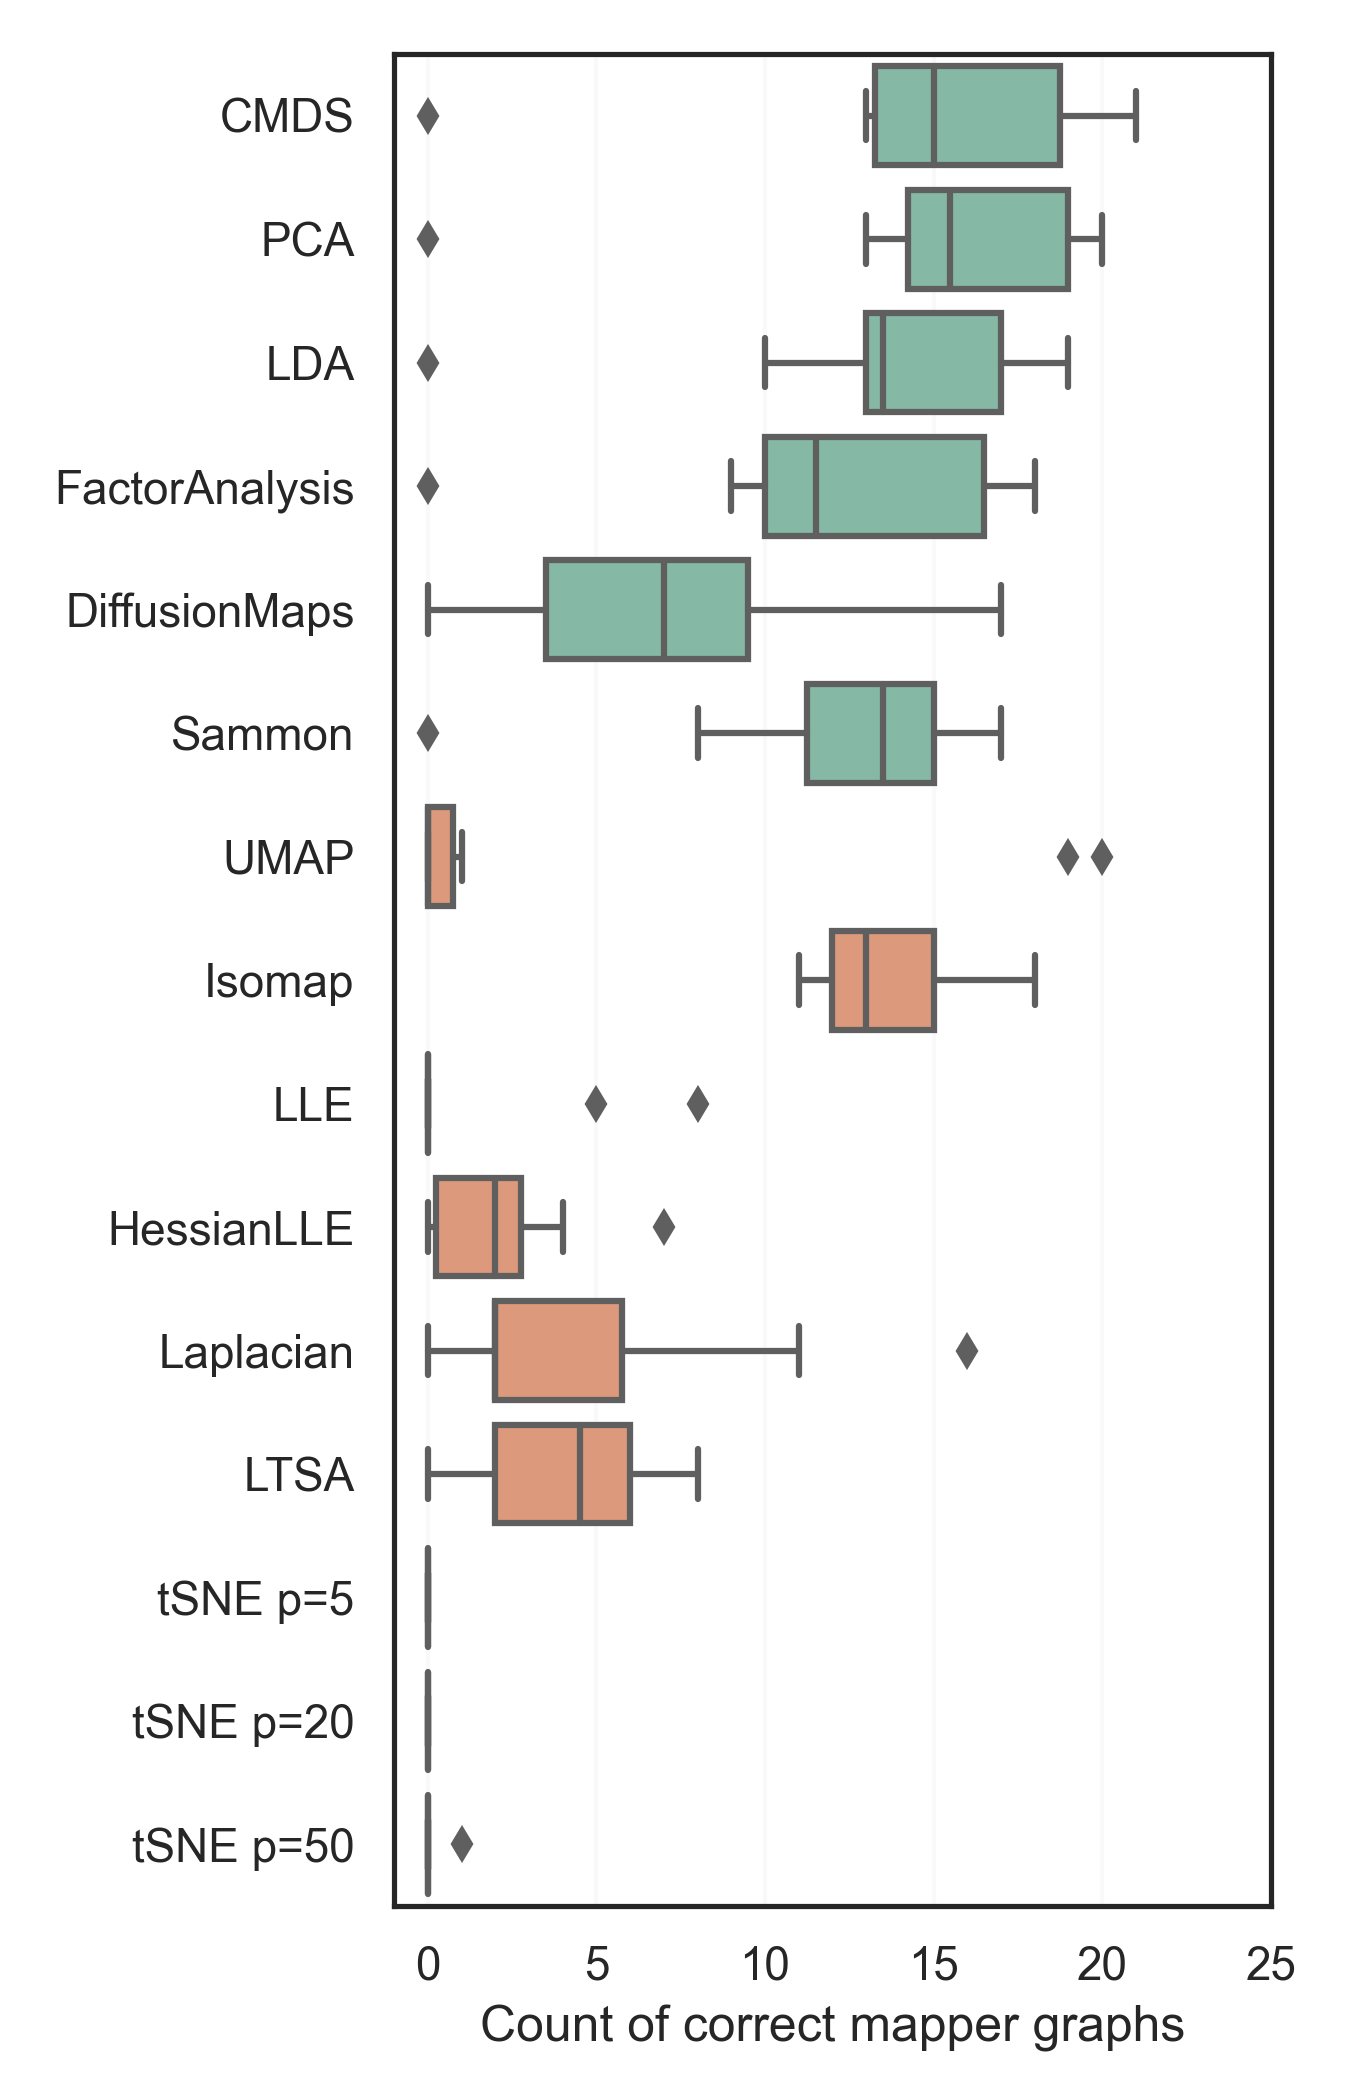

In [4]:
imgpath = 'results/w3c/analysis/mappers_w3c_embed1.json/embeds_analysis.png'
display(IPyImage(filename=os.path.join('../', imgpath)))

In [5]:
embeds = [
    'CMDS',
    'PCA',
    'UMAP',
    'Isomap',
    'tSNE p=5']

plt.figure(figsize=(6,3))
ax = None
# for e in embeds:
fdf = filter_dataframe(df, {'embed': embeds})
fdf['order'] = fdf.apply(lambda row: embeds.index(row['embed']), axis=1)
ax = sns.lineplot(data=fdf, x='K', y='count', hue='order', ax=ax, palette='Set2_r', linewidth=4)

ax.set(xscale='log')
k_vals = sorted(fdf['K'].drop_duplicates().tolist())
ax.set(xticks=k_vals)
ax.set(xticklabels=k_vals)
plt.ylabel('Count of correct mapper graphs')
plt.ylim([-1, 25])
plt.grid(alpha=0.3)
plt.legend(embeds, bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
savefig_path = os.path.join(
        datadir, 'selected_embed_results.png')
plt.savefig(savefig_path, dpi=250)
# plt.show()
plt.close()

/var/folders/jl/fywysbss6b348fk_ncy9l7mr0000gn/T/ipykernel_74280/369920137.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fdf['order'] = fdf.apply(lambda row: embeds.index(row['embed']), axis=1)


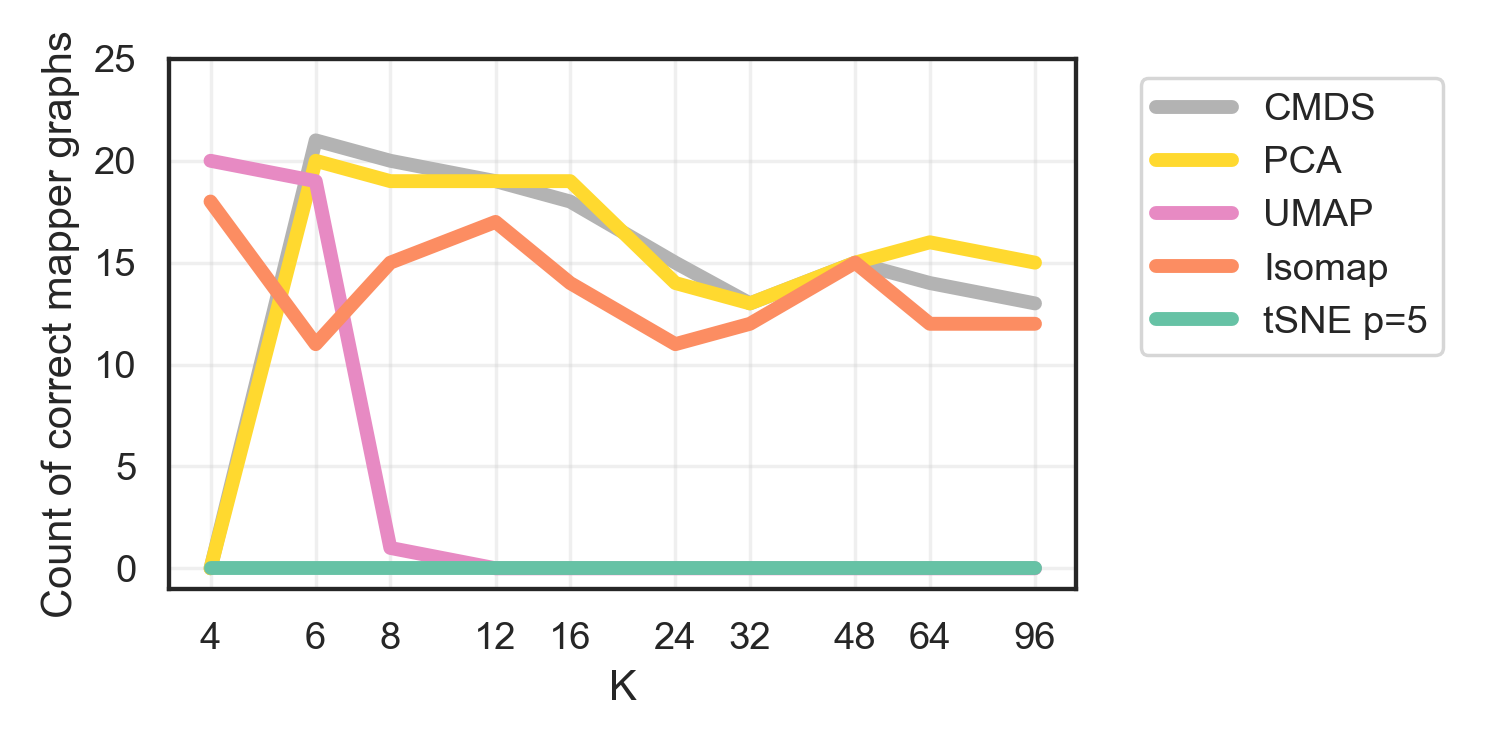

In [6]:
imgpath = 'results/w3c/analysis/mappers_w3c_embed1.json/selected_embed_results.png'
display(IPyImage(filename=os.path.join('../', imgpath)))